<a href="https://colab.research.google.com/github/tmcque9/ConcreteCompressiveStrength/blob/main/Concrete_Compressive_Strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Concrete Compressive Strength

Concrete is a composite material composed of fine and course aggregate mixed with a binder and cured over time.  It has been used for thousands of years in everything from small home projects to massive works of civil engineering that last hundreds of years.  

The compressive strength of concrete, which is what makes it useful, is a non-linear function of age and ingredients.  In this project, we will use public data derived experimentally from a lab to predict the compressive strength of a mixture (given in KPa) cured for a set amount of time (in days).

In [91]:
#@title Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge, LogisticRegression, SGDRegressor, Lasso, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from scipy.stats import gaussian_kde
import warnings
# warnings.filterwarnings('ignore')

## Python Libraries Used:
* Numpy
* Pandas
* MatPlotLib
* SciKit-Learn
* XGBoost

In [3]:
#@title
data = pd.read_csv('Concrete Compressive Strength.csv')
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

# Data

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.


| Component | Data Type | Measurement | Description |
| -- | -- | -- | -- |
|Cement | quantitative |  kg in a m3 mixture |  Input Variable |
|Blast Furnace Slag | quantitative | kg in a m3 mixture | Input Variable|
|Fly Ash | quantitative | kg in a m3 mixture | Input Variable|
|Water| quantitative | kg in a m3 mixture | Input Variable|
|Superplasticizer | quantitative | kg in a m3 mixture | Input Variable|
|Coarse Aggregate | quantitative | kg in a m3 mixture | Input Variable|
|Fine Aggregate  | quantitative | kg in a m3 mixture | Input Variable|
|Age | quantitative | Day (1~365) | Input Variable|
|Concrete compressive strength | quantitative | MPa | Output Variable|


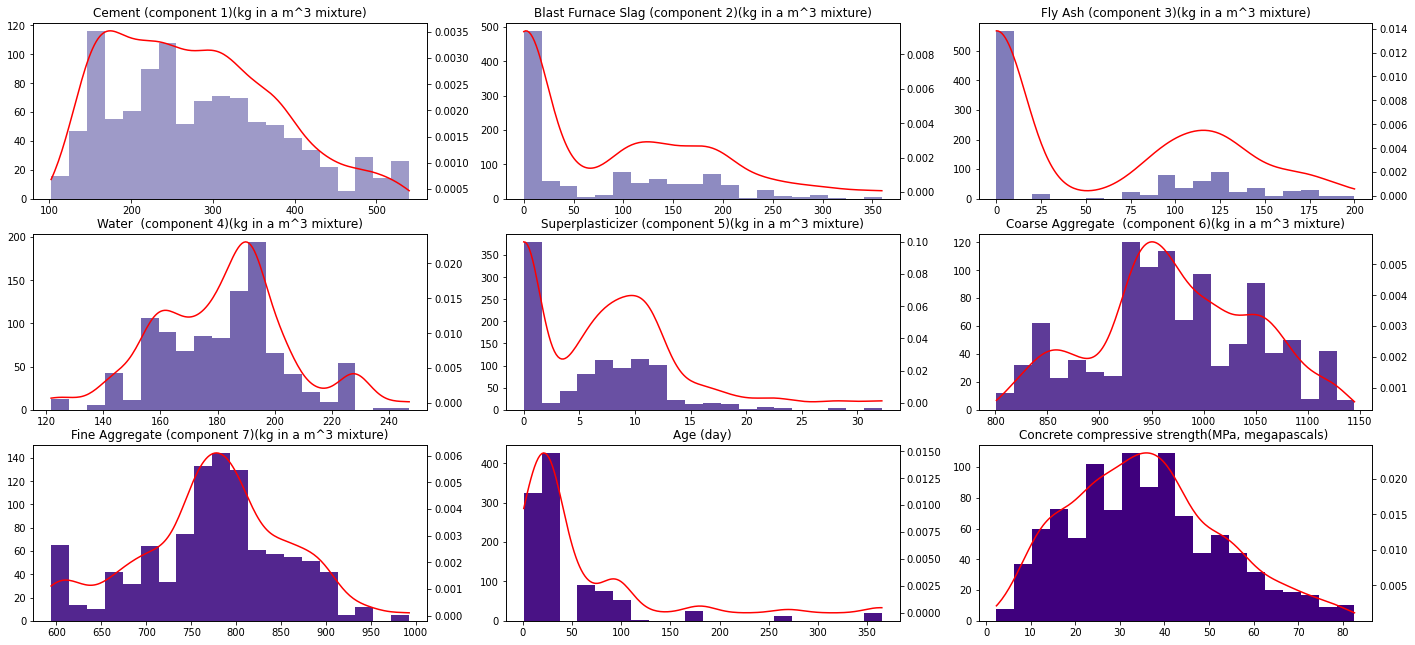

In [86]:
#@title Checking to see that there is variation in the data for each feature.
fig, axes = plt.subplots(3, 3, figsize=(24,11))

cmap = get_cmap('Purples')

for ax1, column, color in zip(axes.flat, [c for c in data.columns], [cmap(x) for x in np.linspace(0.5, 1.0, 9)]):
  col = data[column]
  ax1.hist(col, bins=20, color=color)

  ax2 = ax1.twinx()
  _max = col.max()
  _min = col.min()
  density = gaussian_kde(col)
  xs = np.linspace(_min,_max,200)
  density.covariance_factor = lambda : 0.25
  density._compute_covariance()
  ax2.plot(xs,density(xs), c='red')
    
  ax1.set_title(column)

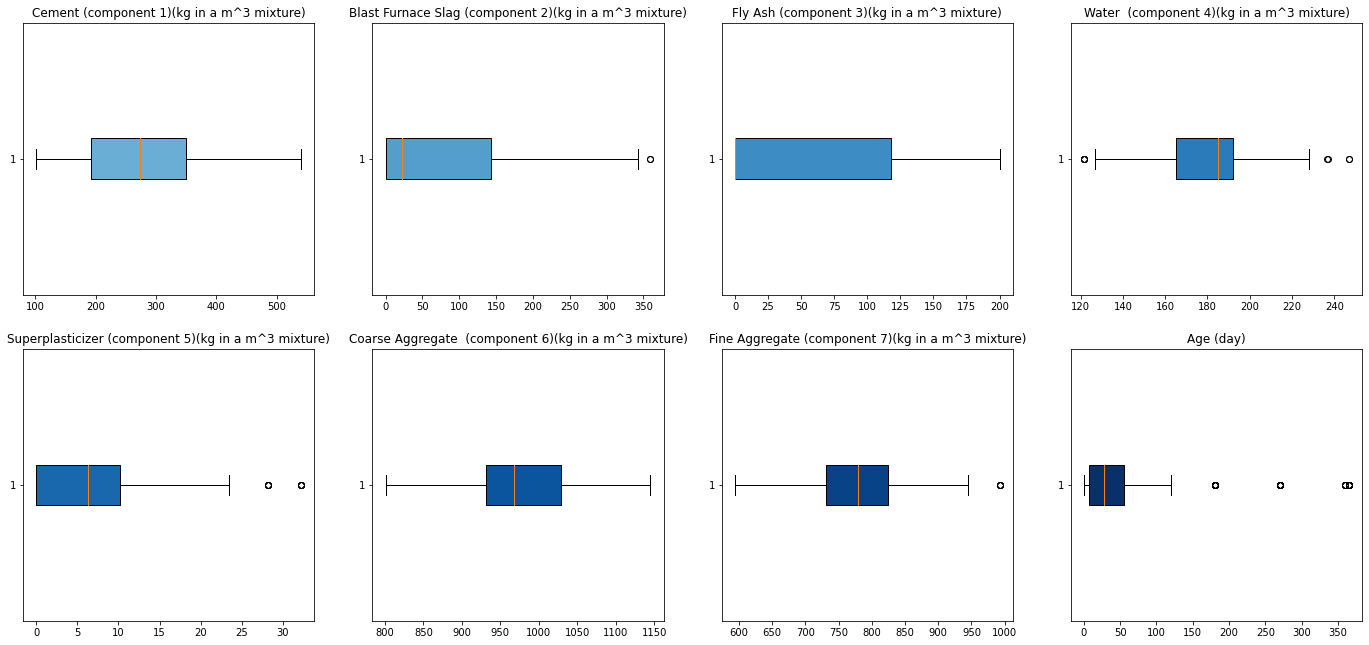

In [101]:
#@title Check for Outliers
fig, axes = plt.subplots(2, 4, figsize=(24,11))

cmap = get_cmap('Blues')

for ax, column, color in zip(axes.flat, [c for c in X.columns], [cmap(x) for x in np.linspace(0.5, 1.0, 8)]):
  plot = ax.boxplot(x = X[column], data=X, vert=False, notch=False, patch_artist=True)
  ax.set_title(column)
  for box in plot['boxes']:
    box.set_facecolor(color)

There are outliers, however removing them won't make a difference in the final result.

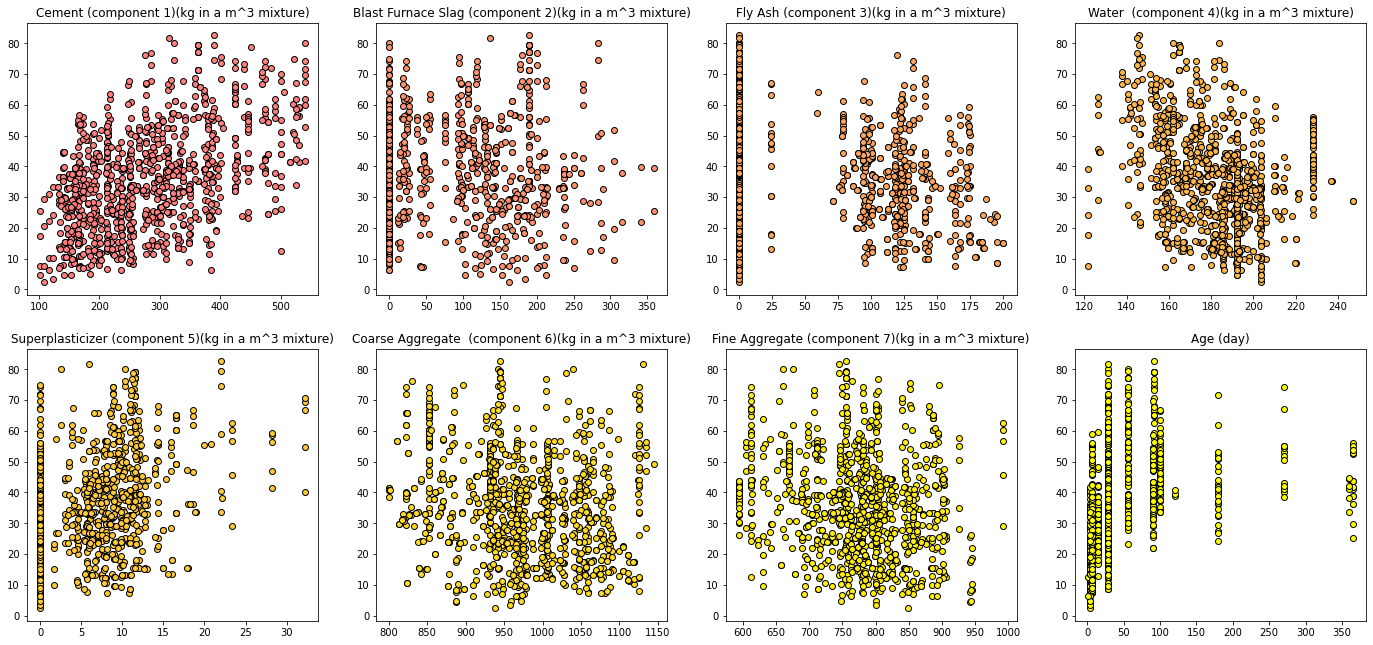

In [107]:
#@title How features are relted to the Target column
fig, axes = plt.subplots(2, 4, figsize=(24,11))

cmap = get_cmap('spring')

for ax, column, color in zip(axes.flat, [c for c in X.columns], [cmap(x) for x in np.linspace(0.5, 1.0, 8)]):
  plot = ax.scatter(X[column], Y, color=color, edgecolors='black')
  ax.set_title(column)

''

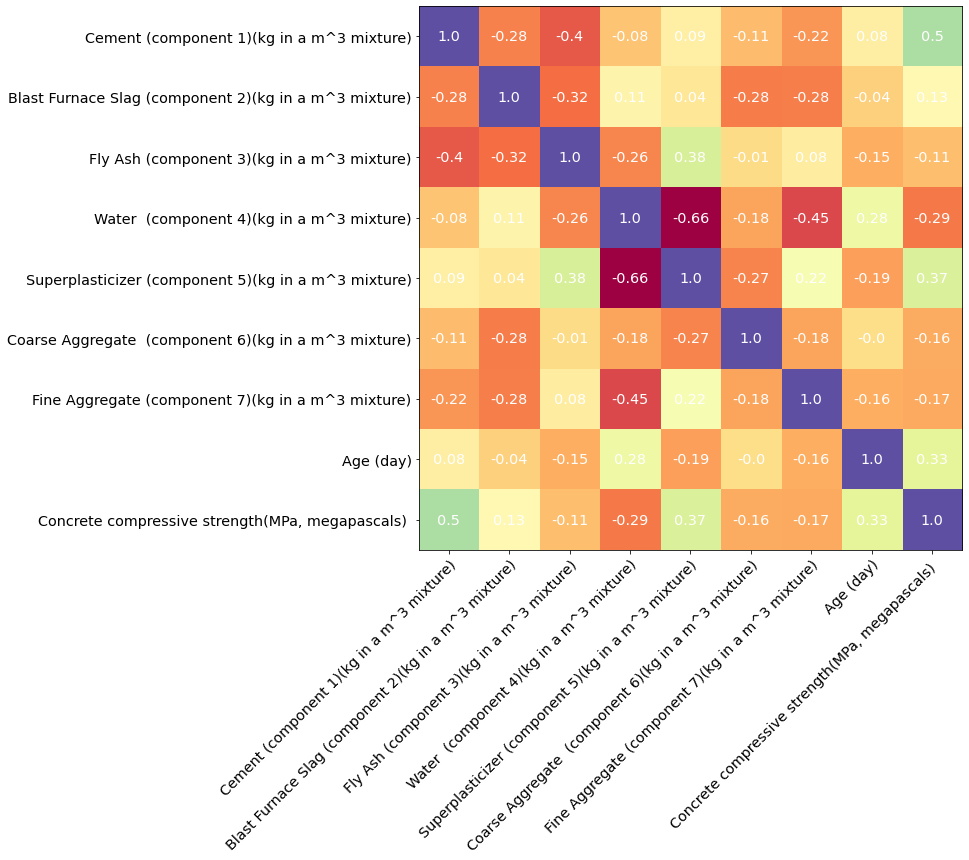

In [145]:
#@title How features are related to the Target column
fig, ax = plt.subplots(figsize=(10,10))

cmap = get_cmap('Spectral')

corr = data.corr()
ax.imshow(corr, cmap=cmap)

# We want to show all ticks...
ax.set_xticks(np.arange(len(data.columns)))
ax.set_yticks(np.arange(len(data.columns)))
# ... and label them with the respective list entries
ax.set_xticklabels(data.columns, fontsize='x-large')
ax.set_yticklabels(data.columns, fontsize='x-large')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(data.columns)):
    for j in range(len(data.columns)):
        text = ax.text(j, i, np.round(corr.iloc[i, j], 2), ha="center", va="center", color="w", fontsize='x-large')
;

There is a strong correlation between cement and compressive strength, however this is a given. No other features appear to be correlated.

In [4]:
#@title Create a Python dictionary with several estimators to test
regressors = {
    'svr_linear': SVR(kernel='linear'),
    'svr_rbf': SVR(kernel='rbf'),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elasticnet': ElasticNet(),
    'gradient_boost': GradientBoostingRegressor(),
    'ada_boost': AdaBoostRegressor(),
    'random_forest': RandomForestRegressor(),
    'hist_gradient': HistGradientBoostingRegressor(),
    'xgboost': XGBRegressor(objective ='reg:squarederror'),
    'bagging': BaggingRegressor(),
    'extra_trees': ExtraTreesRegressor()
}

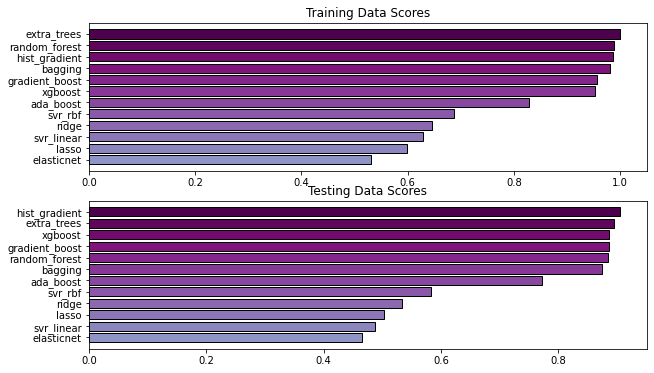

In [146]:
#@title Calculate the accuracy of the chosen estimators
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

accuracy = pd.DataFrame(columns=['estimator', 'train', 'test'])

for est_name, est in regressors.items():
  pipe = Pipeline([
                   ('scaler', StandardScaler()),
                   ('estimator', est)
  ])

  pipe.fit(x_train, y_train)

  accuracy = accuracy.append({
        'estimator': est_name,
        'train': pipe.score(x_train, y_train),
        'test': pipe.score(x_test, y_test)
  } , ignore_index=True)

cmap = get_cmap('BuPu')

colors = [cmap(x) for x in np.linspace(0.5, 1.0, len(regressors))]

best_estimator_list = accuracy[accuracy.train >= 0.90].estimator.tolist()

fig, axes = plt.subplots(2, 1, figsize=(10,6))
acc1 = accuracy.sort_values('train')
axes[0].barh(acc1.estimator, acc1.train, color=colors, edgecolor='black')
axes[0].set_title('Training Data Scores')
acc2 = accuracy.sort_values('test')
axes[1].barh(acc2.estimator, acc2.test, color=colors, edgecolor='black');
axes[1].set_title('Testing Data Scores');

In [147]:
# @title

# best_estimators = [(e, regressors[e]) for e in best_estimator_list]

# random_states = list(range(200))

# random_state_scores = []

# for rs in random_states:
#   x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=rs)
#   reg = VotingRegressor(estimators=best_estimators)
#   reg.fit(x_train, y_train)
#   random_state_scores.append(reg.score(x_test, y_test))
# s = pd.Series(random_state_scores)
# max = s.max()
# max_idx = s.idxmax()
# max_idx = 183 #already calculated with this dataset
# fig, ax = plt.subplots(figsize=(20,6))
# ax.plot(scores)
# ax.axvline(max_idx, c='red')
# ax.set_title(f'Max: {np.round(max, 2)} Max State: {max_idx}');

In [148]:
#@title
# weights = list(combinations(np.arange(0.1, 1.0, 0.1), len(best_estimators)))

# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=max_idx)
# weight_scores = []

# for w in weights:
#   reg = VotingRegressor(estimators=best_estimators, weights=w)
#   reg.fit(x_train, y_train)
#   weight_scores.append(reg.score(x_test, y_test))

# best_score = np.max(weight_scores)
# index = weight_scores.index(best_score)
# fig, ax = plt.subplots(figsize=(20,6))
# ax.plot(weight_scores)
# ax.set_title(f"Weighting Strategy - Best Score: {np.round(best_score, 2)} Best Weights: {weights[index]}")
# ax.axvline(x=index, color='red');

In [149]:
#@title

best_weights = [0.1, 0.2, 0.5, 0.6, 0.7, 0.8]
best_random_state = 183

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=best_random_state)

vreg = VotingRegressor(estimators=best_estimators, weights=best_weights)
reg.fit(x_train, y_train)
y_pred = reg.predict(X)
mse = mean_squared_error(Y, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(Y, y_pred)

pd.DataFrame([
              ['Mean Squared Error', mse],
              ['Root Mean Squared Error', rmse],
              ['R-Squared', r_squared]])

,0,1
0,Mean Squared Error,8.141652
1,Root Mean Squared Error,2.853358
2,R-Squared,0.970798


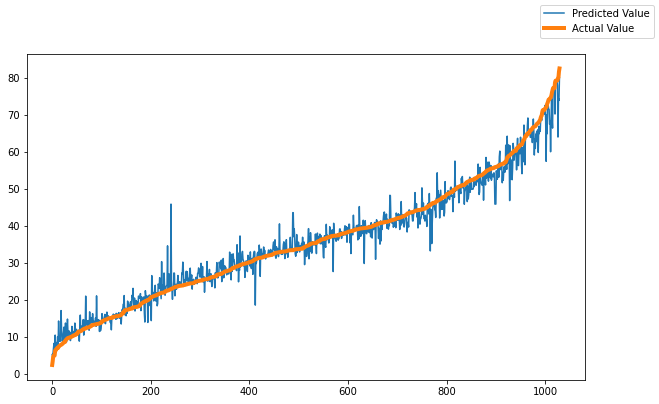

In [150]:
#@title
df = pd.DataFrame({
    'target': Y,
    'prediction': reg.predict(X)
})

df.sort_values('target', inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
x = list(range(len(X)))
ax.plot(x, df.prediction, label='Predicted Value', )
ax.plot(x, df.target, lw=4, label='Actual Value')
fig.legend();

# Using the data
In this area you can change components of the mixture and see how it compares to the lab-derived values.

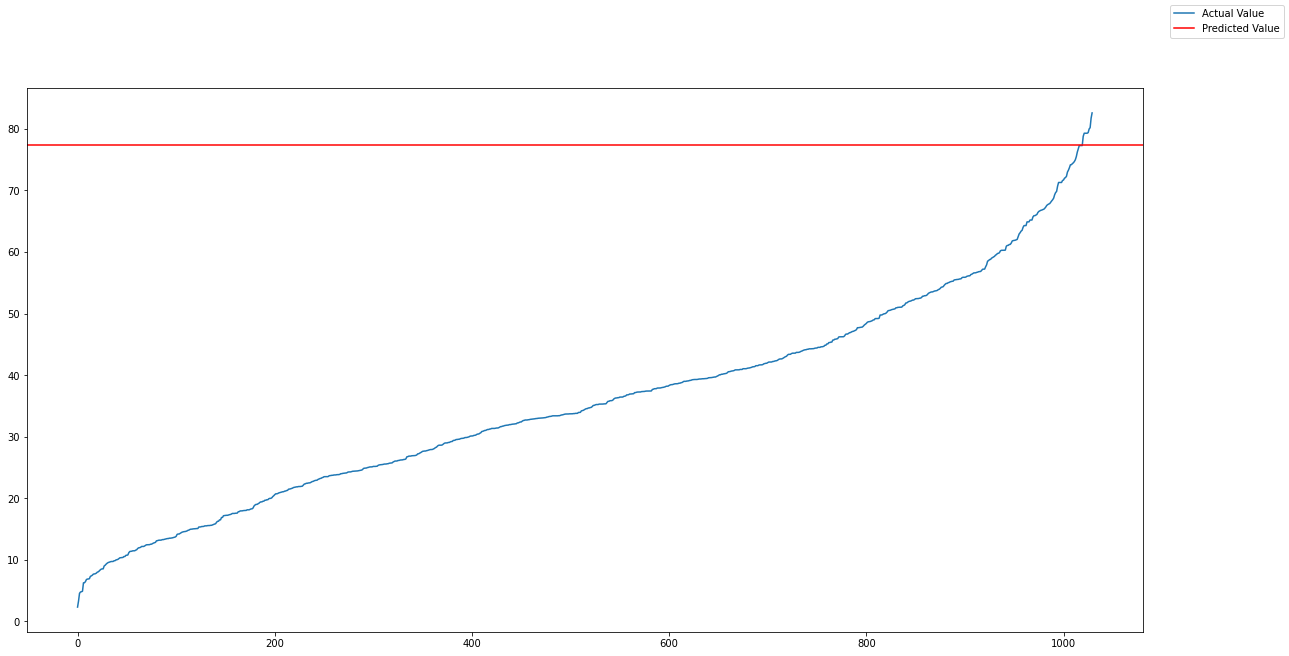

In [ ]:
#@title Generate a Mix experimentally
cement_component = 390 #@param {type:"slider", min:100, max:540, step:1}
blast_furnace_slag = 190 #@param {type:"slider", min:0, max:360, step:1}
fly_ash = 0 #@param {type:"slider", min:0, max:200, step:1}
water = 145 #@param {type:"slider", min:120, max:250, step:1}
superplasticizer = 22.1 #@param {type:"slider", min:0.0, max:32, step:0.1}
coarse_aggregate =  945 #@param {type:"slider", min:800, max:1200, step:1}
fine_aggregate = 755 #@param {type:"slider", min:500, max:1000, step:1}
age = 90 #@param {type:"slider", min:0, max:100, step:1}

Xe = X.append({
  'Cement (component 1)(kg in a m^3 mixture)': cement_component,
  'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': blast_furnace_slag,
  'Fly Ash (component 3)(kg in a m^3 mixture)': fly_ash,
  'Water  (component 4)(kg in a m^3 mixture)': water,
  'Superplasticizer (component 5)(kg in a m^3 mixture)': superplasticizer,
  'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': coarse_aggregate,
  'Fine Aggregate (component 7)(kg in a m^3 mixture)': fine_aggregate,
  'Age (day)': age
}, ignore_index=True)

index = len(X)

y_sorted= Y.sort_values();
y_pred = reg.predict(Xe)
fig, ax = plt.subplots(figsize=(20,10))
x = list(range(len(X)))
ax.plot(x, y_sorted, label='Actual Value', )
ax.axhline(y_pred[index], color='red', label='Predicted Value')
fig.legend();

# Citations

I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998).